In [25]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import skimage as ski
from scipy import ndimage
import os
import fnmatch

import vtk
from vtk.util import numpy_support
from scipy.spatial import Delaunay, Voronoi, voronoi_plot_2d
from skimage.measure import label
from matplotlib.path import Path
import matplotlib as mpl

In [3]:
path  = "data"

data = {}

for file in sorted(fnmatch.filter(os.listdir(path),"*.jpg")):
    file_name = os.path.splitext(file)[0]
    data[file_name] = {}

    data[file_name]["image"] = ski.io.imread(os.path.join(path,file), as_gray=True)
    print(file,file_name)

FVC40_011_000.jpg FVC40_011_000
FVC40_013_005.jpg FVC40_013_005
FVC50_011_002.jpg FVC50_011_002
FVC50_011_015.jpg FVC50_011_015
FVC60_011_011.jpg FVC60_011_011
FVC60_013_006.jpg FVC60_013_006


In [1]:
for key, item in data.items():


    thresholded_image = ski.filters.threshold_local(item["image"], block_size=5, method='mean', offset=0.02)

    # Convert thresholded image to binary
    binary_image = thresholded_image > thresholded_image.mean()


    # Distance transform
    distance_map = ndimage.distance_transform_edt(binary_image)

    # Watershed segmentation
    markers = ndimage.label(distance_map > 10)[0]
    labels = ski.segmentation.watershed(-distance_map, markers, mask=binary_image)

    # Compute centroid of each labeled region
    regions = ski.measure.regionprops(labels)
    centroids = [region.centroid for region in regions]

    fig, axes = plt.subplots(1, 3, figsize=(2*3.5, 3.5))
    axes[0].imshow(item["image"], cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(binary_image, cmap='gray')
    axes[1].set_title('Thresholded Image')
    axes[1].axis('off')


    img = axes[2].imshow(labels, cmap='cividis')
    for centroid in centroids:
        axes[2].plot(centroid[1], centroid[0], 'ro')  # Plot centroid
    axes[2].axis('off')


NameError: name 'data' is not defined

## MASK-RCNN segmentations

In [5]:
path  = "data"

data_mask = {}

for file in sorted(fnmatch.filter(os.listdir(path),"*.jpg")):
    file_name = os.path.splitext(file)[0]
    data_mask[file_name] = {}

    data_mask[file_name]["image"] = ski.io.imread(os.path.join(path,file), as_gray=True)
    data_mask[file_name]["labels"] = np.load(os.path.join(path,file_name + "_labels.npy"))
    print(file,file_name)

FVC40_011_000.jpg FVC40_011_000
FVC40_013_005.jpg FVC40_013_005
FVC50_011_002.jpg FVC50_011_002
FVC50_011_015.jpg FVC50_011_015
FVC60_011_011.jpg FVC60_011_011
FVC60_013_006.jpg FVC60_013_006


In [6]:
# Define a function to create a mask for a given triangle
def triangle_mask(triangle, shape):
    vertices = np.array(triangle)
    vertices[:,[0, 1]] = vertices[:,[1, 0]]
    path = Path(vertices)
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    points = np.vstack((x.flatten(), y.flatten())).T
    mask = path.contains_points(points)
    return mask.reshape(shape)

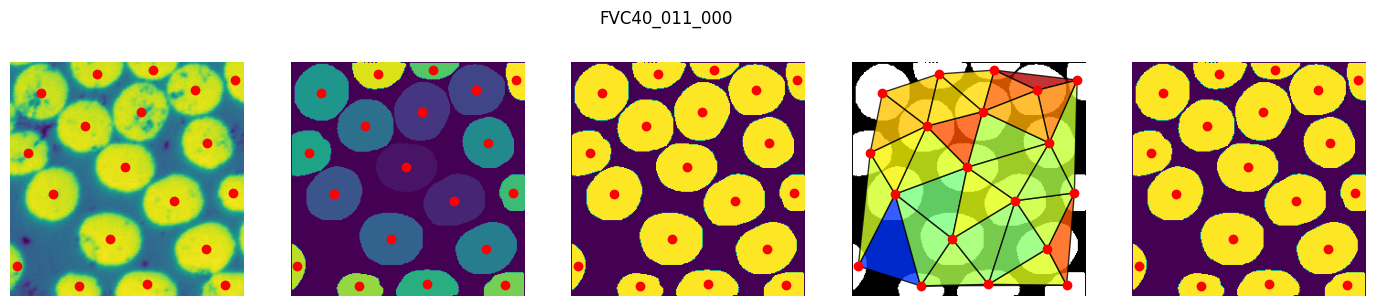

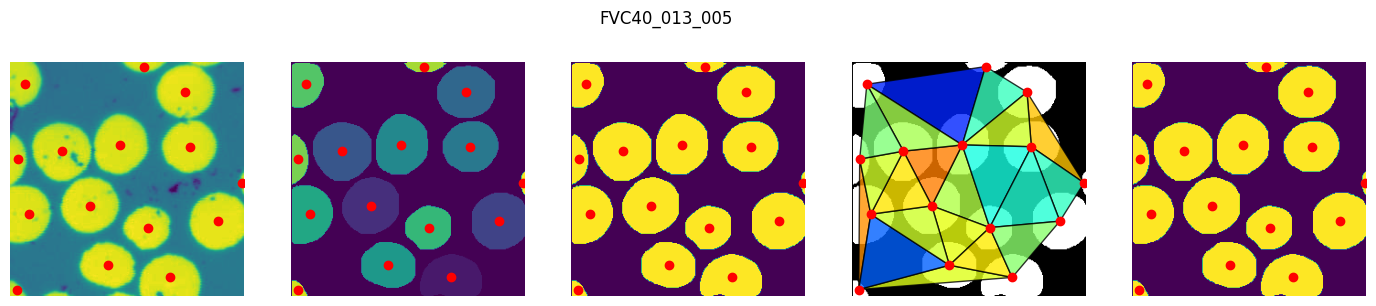

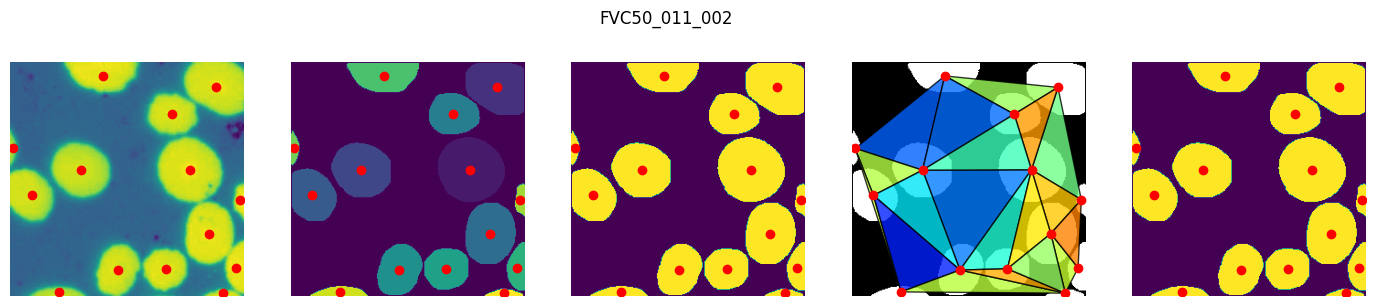

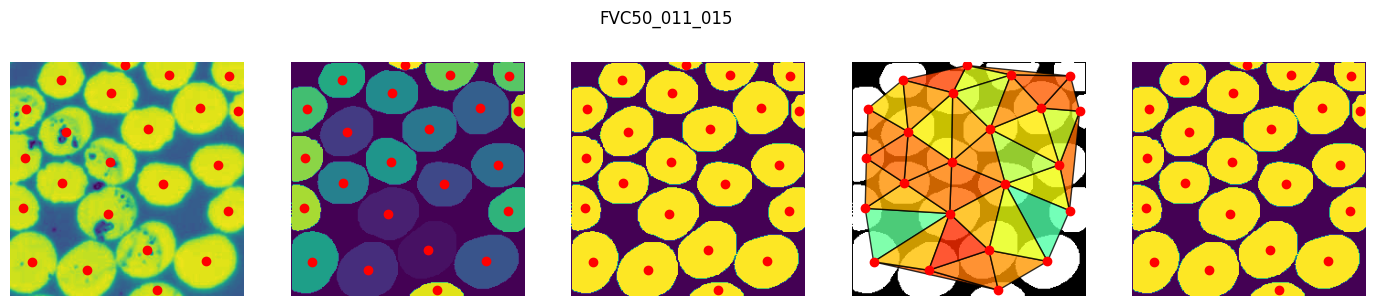

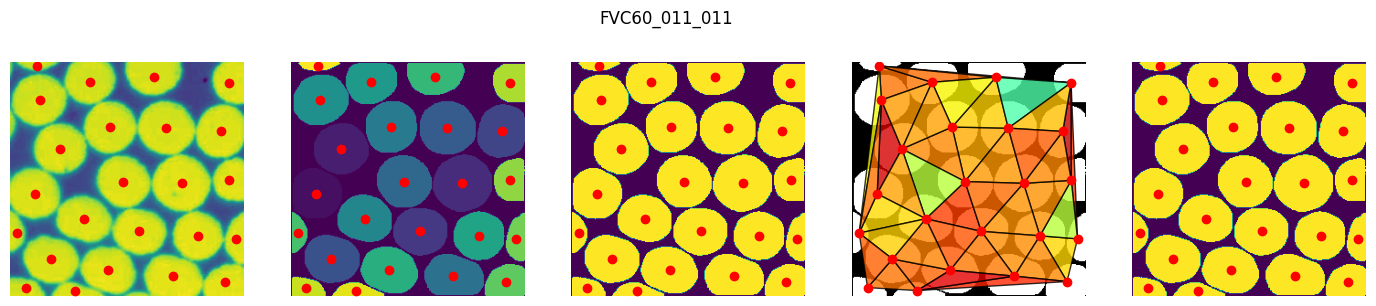

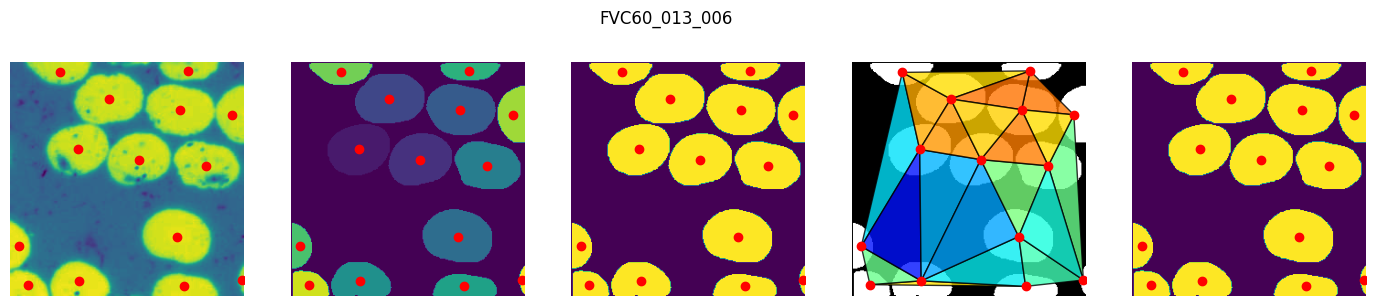

In [7]:
for name, item in data_mask.items():
    n = 5
    fig, axs = plt.subplots(1,n,figsize = (n*3.5,3.5))
    fig.suptitle(name)

    regions = ski.measure.regionprops(item["labels"])
    centroids = np.array([region.centroid for region in regions])
    labels_ph = item["labels"] > 0 
    
    tri = Delaunay(centroids)

    axs[0].imshow(item["image"])
    axs[1].imshow(item["labels"])
    axs[2].imshow(labels_ph)
    axs[3].imshow(labels_ph,cmap="grey")
    axs[4].imshow(labels_ph)
    
    
    # for centroid in centroids:
    for ax in axs:
        ax.plot(centroids[:,1], centroids[:,0], 'ro')  # Plot centroid
    
    # array = np.zeros_like(labels_ph).astype(np.uint8)
    phi = []
    for i, triangle in enumerate(centroids[tri.simplices[:]]):
        
        # Create mask for the triangle
        mask = triangle_mask(triangle, labels_ph.shape)
        # Apply the mask to the 2D array
        # array[mask] = i+1
        phi.append(np.count_nonzero(labels_ph[mask] == 1)/np.sum(mask))



    cmap = mpl.colormaps['jet']
    for simplex, p in zip(tri.simplices,phi):
        axs[3].fill(centroids[simplex, 1], centroids[simplex, 0], facecolor=cmap(p), edgecolor='black', alpha=0.8)

    # axs[4].imshow(array)

    for ax in axs: ax.axis('off')

    data_mask[name]["mask"] = labels_ph
    data_mask[name]["centroids"] = centroids

### Ripley K-Function

$$ \mathcal{D}_K(h | d_{ij}) = \frac{A}{N^2} \sum_i\sum_{i \neq j} \frac{I(d_{ij}\leq h)}{\omega(l_i,l_j)}$$

Ripley's K- function can also be compared with the theoretical model od a random Poisson-distribution of points given by:

$$ \mathcal{D}_{K}(h | d_{ij} \in \mathcal{P} ) = \pi h^2$$

However, this allows for the definition of the simple loss function (error function):


$$\mathcal{L}(h) = \sqrt{\frac{\mathcal{D}_K(h | d_{ij})}{\pi}} - h  $$

### Pair Distribution Function

$$ g(h) = \frac{1}{2\pi h} \frac{\partial\mathcal{D}_K(h | d_{ij})}{\partial h}$$



In [8]:
def ripley_k(data_points, h,A):
    """
    Compute Ripley's K-function for a given set of data points.

    Parameters:
        data_points (ndarray): 2D array of shape (n, 2) containing (x, y) coordinates of data points.
        h (ndarray): Array of distances for which to compute Ripley's K-function D(h).

    Returns:
        k_values (ndarray): Array of K-function values corresponding to each radius.
    """
    n = len(data_points)
    distances = squareform(pdist(data_points))

    k_values = np.zeros_like(h)

    for i, r in enumerate(h):
        count = np.sum(distances <= r, axis=1) - 1  # Exclude the point itself
        k_values[i] = A*np.mean(count) / n

    return k_values


In [9]:
def pairwise_distribution(h,k_values):
    """
    Compute pairwise distribution function g(h) using Ripley's K-function.

    Parameters:
        data_points (ndarray): 2D array of shape (n, 2) containing (x, y) coordinates of data points.
        radii (ndarray): Array of radii for which to compute the pairwise distribution function.

    Returns:
        g_values (ndarray): Array of pairwise distribution function values corresponding to each radius.
    """
    
    # Compute the derivative of Ripley's K-function with respect to distance h
    dk_dh = np.gradient(k_values, h)
    
    # Compute pairwise distribution function g(h)
    g_values = dk_dh / (2 * np.pi * h)
    
    return g_values

In [10]:
# Generate random points within a square region
np.random.seed(0)
n_points = 14
data_points = np.random.rand(n_points, 2) * 256  # Random points within [0, 10] x [0, 10] region

# Define radii for Ripley's K-function
r_max = 256/2
dr = 0.1
r_fibre = 30  ## fibre radius in PX
h = np.arange(r_fibre, r_max, dr)

A = 256**2


In [11]:
def loss_k(h,k_values):
    return np.sqrt(k_values/np.pi)-(h-r_fibre)

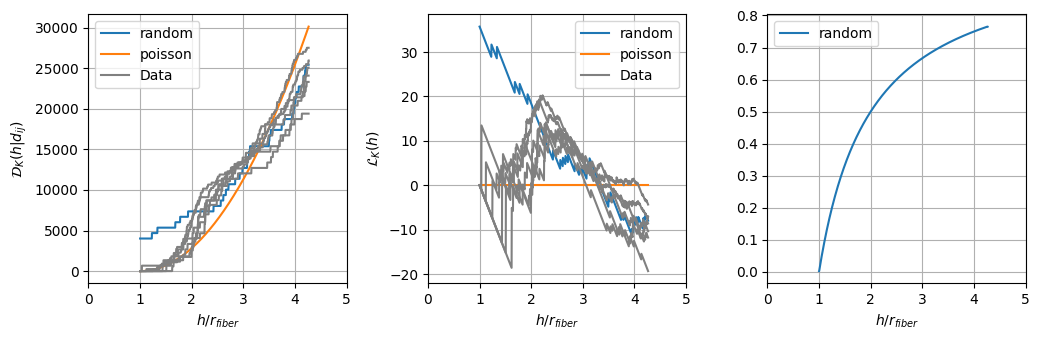

In [12]:
n = 3
fig, axs = plt.subplots(1,n,figsize = (n*3.5,3.5))

## Compute Ripley's K-function
k_values_random = ripley_k(data_points, h,A)
axs[0].plot(h/r_fibre, k_values_random)
axs[1].plot(h/r_fibre,loss_k(h,k_values_random))
# axs[2].plot(h/r_fibre,pairwise_distribution(h,k_values_random), label="random")
##  Ripley's K-function Poisson 
axs[0].plot(h/r_fibre,np.pi*(h-r_fibre)**2)
axs[1].plot(h/r_fibre,loss_k(h,np.pi*(h-r_fibre)**2) )
axs[2].plot(h/r_fibre,pairwise_distribution(h,np.pi*(h-r_fibre)**2))


for name, item in data_mask.items():
    k_values = ripley_k(item["centroids"], h,A)

    axs[0].plot(h/r_fibre, k_values,color="grey")
    axs[1].plot(h/r_fibre,loss_k(h,k_values),color="grey")
    # axs[2].plot(h/r_fibre,pairwise_distribution(h,k_values),color="grey",label="data")





for ax in axs: ax.grid(),ax.legend(["random","poisson",'Data']),ax.set_xlim(0,5),ax.set_xlabel(r"$h/r_{fiber}$")

axs[0].set_ylabel(r"$\mathcal{D}_K(h | d_{ij})$")
axs[1].set_ylabel(r"$\mathcal{L}_K(h)$")
fig.tight_layout()




In [21]:
for name , item in data_mask.items():

    np.save(f"out/{name}_mask.npy",item["mask"].astype(np.uint8))

## Descitptor based approach

In [13]:
import mcrpy

In [14]:
limit_to = 16
descriptor_types = ['Correlations']

In [15]:
characterization_settings = mcrpy.CharacterizationSettings(descriptor_types=descriptor_types, 
    limit_to=limit_to)

2024-05-07 15:11:05.781683: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-07 15:11:05.781710: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-07 15:11:05.781716: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-07 15:11:05.781779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-07 15:11:05.782043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-07 15:11:06.055109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


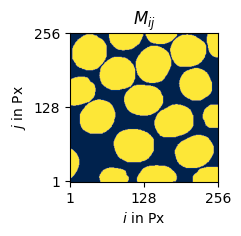

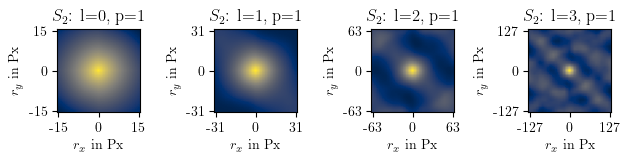

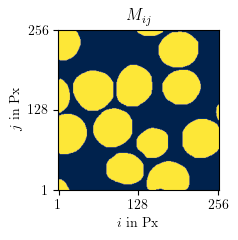

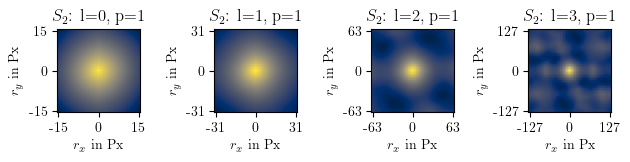

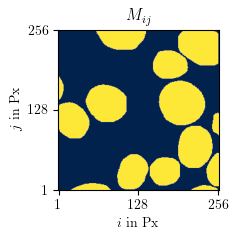

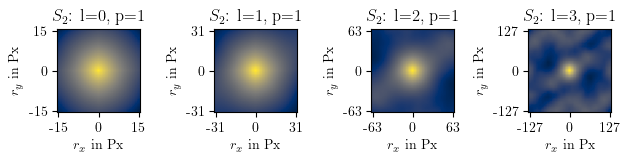

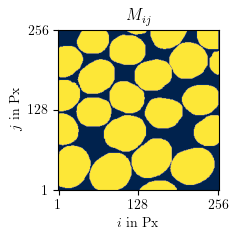

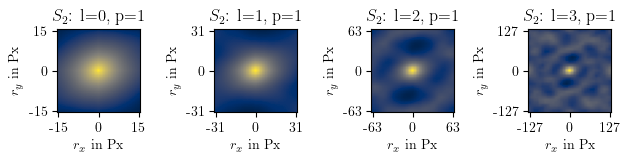

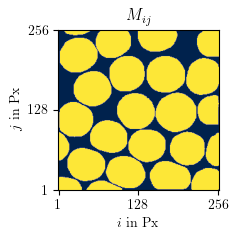

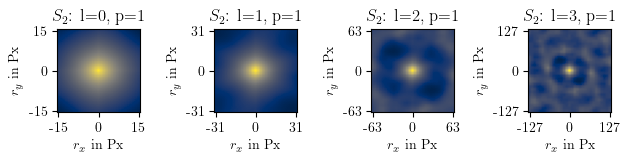

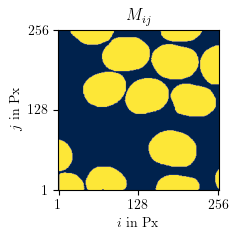

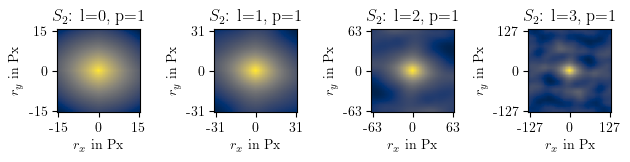

In [16]:

for name, item in data_mask.items():

    ms = mcrpy.Microstructure(item["mask"].astype(np.uint8))
    descriptor = mcrpy.characterize(ms, characterization_settings)
    mcrpy.view(ms)
    mcrpy.view(descriptor)

In [27]:
for name, item in data_mask.items():

    mask = np.tile(item["mask"][:, :, np.newaxis], (1, 1, 1)).astype(np.int64)
    # Create a VTKImageData object
    image_data = vtk.vtkImageData()
    image_data.SetDimensions(tuple(x+1 for x in mask.shape)) ## important add +1 to every dimension

    # Flatten the scalar data
    flat_mask = mask.flatten(order='F')
    vtk_scalar_array = vtk.vtkLongArray()
    vtk_scalar_array.SetNumberOfComponents(1)
    vtk_scalar_array.SetArray(flat_mask, len(flat_mask), True)
    vtk_scalar_array.SetName("material")

    # Set the scalar data as cell data
    image_data.GetCellData().SetScalars(vtk_scalar_array)



    # Set the spacing and origin of the image data (you may need to adjust this based on your data)
    image_data.SetSpacing(.14E-3, .14E-3, .14E-3) ## TODO set Spacing accordingly to voxel size
    image_data.SetOrigin(0.0, 0.0, 0.0)

    # Write the VTI file
    writer = vtk.vtkXMLImageDataWriter()

    shape_str = 'x'.join(map(str, mask.shape))
    writer.SetFileName(f"out/{name}_{shape_str}.vti")
    writer.SetInputData(image_data)

    writer.Write()

### Cluster Analysis

In [17]:
def compute_s2(ms: np.ndarray):
    """Two-point autocorrelation function of phase 1"""
    ms_fourier = np.fft.rfftn(ms)
    s2_fourier = (ms_fourier * np.conjugate(ms_fourier)) 
    s2 = np.fft.irfftn(s2_fourier) / np.size(ms)
    return np.fft.ifftshift(s2)

def compute_c2(ms: np.ndarray):
    """Cluster correlation function"""
    # do some checks
    assert len(ms.shape) == 3, "array should have 3 indices"
    assert len(set(ms.shape)) == 1, "first implementation needs same number of pixels in all directions"
    assert np.max(ms) <= 1.0, "max should be 1"
    assert np.min(ms) >= 0.0, "min should be 0"
    assert len(np.unique(ms)) == 2, "should be binary and segmented"
    
    # label
    ms_labeled, n_labels = label(ms, return_num=True, connectivity=1)
    assert n_labels > 0
    
    # accumulate s2 of labels to ccf
    # loop implemented manually to save ram
    accumulator = compute_s2(ms_labeled==1)
    for n_label in range(2, n_labels + 1):
        accumulator = accumulator + compute_c2(ms_labeled==n_label)
    c2 = accumulator / n_labels
    return c2


(256, 256, 256)


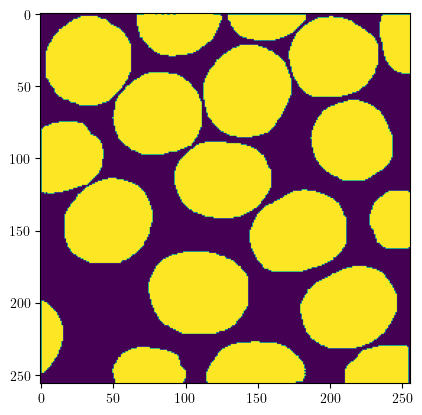

In [31]:
ms = data_mask["FVC40_011_000"]["mask"]
ms = np.tile(ms[:, :, np.newaxis], (1, 1, ms.shape[0])).astype(np.int64)


print(ms.shape)

plt.imshow(ms[:,:,0])

In [32]:
s2 = compute_s2(ms)
c2 = compute_c2(ms)

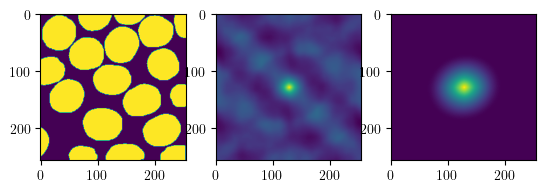

In [40]:
fig, axs = plt.subplots(1,3)

axs[0].imshow(ms[:,:,0])
axs[1].imshow(s2[:,:,0])
axs[2].imshow(c2[:,:,0])

In [44]:
c2_2d = c2[:,:,0]


print(c2_2d.min(),c2_2d.max())

-2.223552783618003e-18 0.031176918431332235


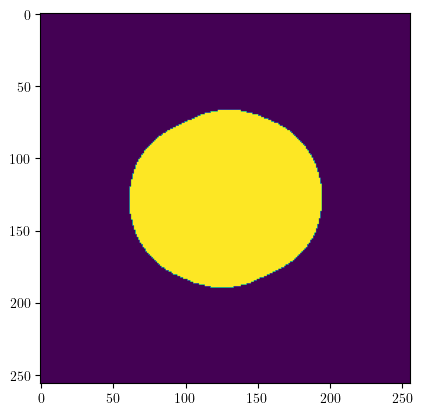

In [56]:
plt.imshow(c2_2d > c2_2d.max() * .001)

regions = ski.measure.regionprops(np.array(c2_2d > c2_2d.max() * .05).astype(np.uint8))
print(regions)

In [57]:
props = ski.measure.regionprops_table(
    np.array(c2_2d > c2_2d.max() * .05).astype(np.uint8),
    properties=('centroid', 'orientation', 'axis_major_length', 'axis_minor_length'),
)
print(props)

{'centroid-0': array([128.]), 'centroid-1': array([128.]), 'orientation': array([-1.31268899]), 'axis_major_length': array([110.12220125]), 'axis_minor_length': array([98.05765085])}
